## looping through transects to plot hovmoller for given spectral index
- [x] user selects a) transect ID range, b) time range, c) index
- [x] bring in transects
- [x] loop through transects
- [x] load in datacube data
- [x] save out as .nc
- [x] load back in as .nc (just to check as will make another nb to plot up transects)
- [x] export as csv 
- [x] export plot with auto name similar to csv

In [1]:
import time
start = time.time()

In [2]:
import os

import numpy as np
import xarray as xr
import rasterio
import geopandas as gpd
import shapely.geometry

import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt

import datacube
from datacube.utils.geometry import Geometry
dc = datacube.Datacube(app='mangrove typology')
from datacube.drivers.netcdf import write_dataset_to_netcdf

from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices

## user inputs

In [3]:
# location of transects file
transects_file = './data/Transects.shp'
transects = gpd.read_file(transects_file)

# Define temporal range
start_of_epoch = '1990-01-01' 
end_of_epoch =  '2020-12-31'
query = {'time': (start_of_epoch, end_of_epoch)}

# select index from https://docs.dea.ga.gov.au/notebooks/Tools/gen/dea_tools.bandindices/#dea_tools.bandindices.calculate_indices
index_selection = 'NDVI'

# select range of transects to run
transects_selection = transects.loc[(transects['Transect_N'] >= 1) & (transects['Transect_N'] <= 1)]
transects_selection

,Id,Transect_N,geometry
0,0,1,"LINESTRING (136.47671 -12.84485, 136.48186 -12..."


#### function required to manipulate geometries

In [4]:
def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))

#### main loop for function

Feature: 1/1
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 378 out of 917 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 378 time steps
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


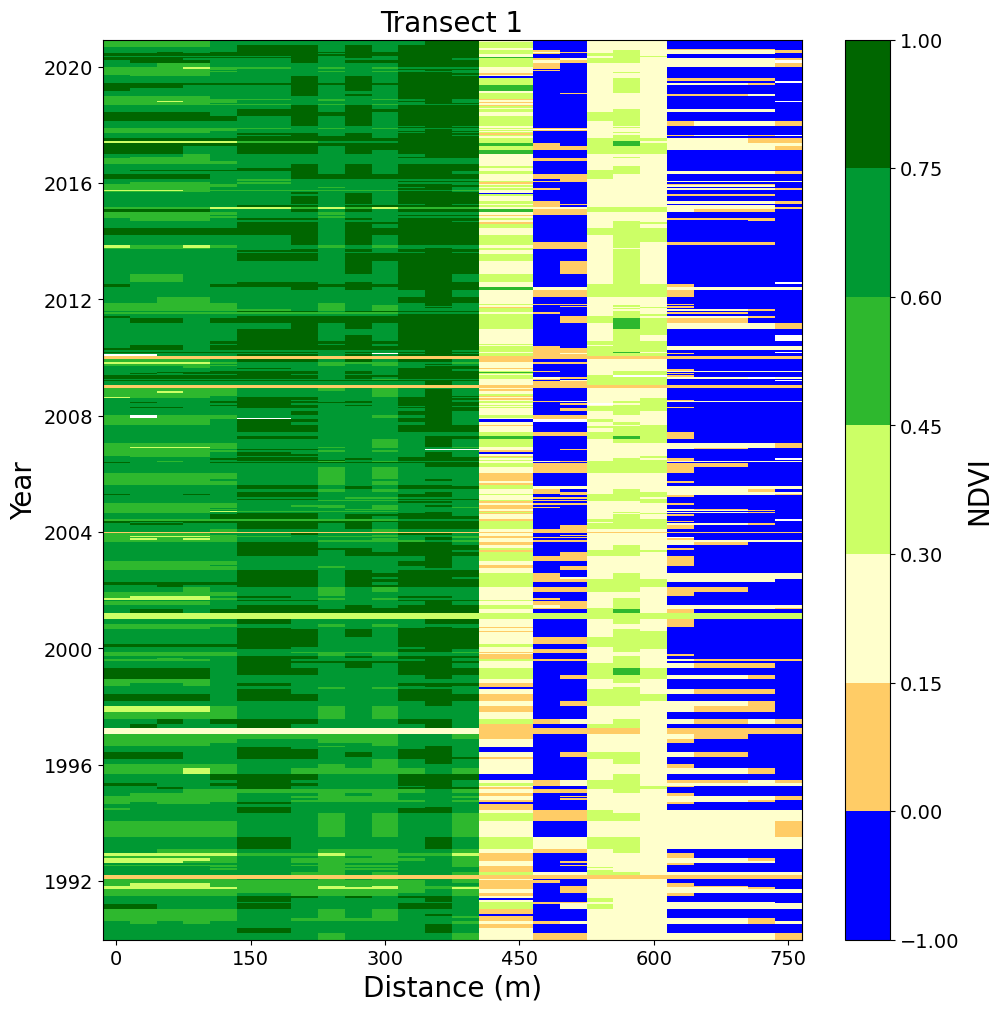

In [5]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in transects_selection.iterrows():
    print(f'Feature: {index + 1}/{len(transects_selection)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=transects_selection.crs)

    # Update the query to include the geopolygon
    query.update({'geopolygon': geom})

    ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              # measurements=['nbart_red', 'nbart_nir'], 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.99, 
              output_crs='EPSG:3577',
              skip_broken_datasets=True,
              ls7_slc_off=True,
              resolution=(-30, 30),
              group_by='solar_day',
              **query)
    
    
    # output raw data
    output_filename = './output/Transect' + str(row['Transect_N']) + '_' + start_of_epoch.split('-')[0] + '_' + end_of_epoch.split('-')[0] + '_Landsat.nc'

    # Check if the file exists and remove it
    if os.path.exists(output_filename):
        os.remove(output_filename)

    write_dataset_to_netcdf(ds, output_filename)
    
    # generate index
    ds_index = calculate_indices(ds,
                           index=index_selection,
                           collection='ga_ls_3',
                           drop=True,
                           inplace=False)
    
    ds_index = ds_index[index_selection]
    
    # get geometry for pd and plotting
    crs_wkt = ds.crs
    geom_w = warp_geometry(geom, transects_selection.crs, crs_wkt)
    
    # multiple distance by pixel resolution (Landsat)
    dist = [i for i in range(0, int(geom_w.length), 30)]
    points = list(zip(*[geom_w.interpolate(d).coords[0] for d in dist]))

    # get dims as array
    y_dim = np.asarray(points[1])
    x_dim = np.asarray(points[0])
    
    # select data for plot
    hov_data = ds_index.sel(x=xr.DataArray(x_dim, dims='distance'),
                            y=xr.DataArray(y_dim, dims='distance'),
                            method='nearest')
    
    # Convert DataArray to DataFrame
    df = hov_data.to_dataframe(name='value').reset_index()

    # Pivot the DataFrame
    df_pivoted = df.pivot(index='time', columns='distance', values='value')
    # make column headings into meters (* 30)
    df_pivoted.columns = (df_pivoted.columns.astype(int) * 30).astype(str)

    # for saving, add in easier to read column for time
    df_pivoted.insert(0, 'day_month_year', df_pivoted.index.strftime('%d-%m-%Y'))

    # save as csv
    df_pivoted.to_csv('./output/Transect' + str(row['Transect_N']) + '_' + 
                      start_of_epoch.split('-')[0] + '_' + end_of_epoch.split('-')[0] + '_' + index_selection + '.csv', 
                      index=False)
    
    
    # Generate the figure
    # This controls the colour map used for plotting index
    ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
    # ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1] # Emma breaks
    ndvi_bounds = [-1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 1] # KR breaks
    ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)
    
    fig = plt.figure(figsize=(11.27,11.69))

    ax = hov_data.plot(x='distance', y='time', yincrease = True, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)

    # Function to modify x-axis tick labels by multiplying by 30 (from pixels to distance (m))
    def multiply_by_30(value, pos):
        return int(value * 30)

    # Apply the custom function to the x-axis tick labels
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(multiply_by_30))

    # Remove color bar (to reset so we can customise)
    ax.colorbar.remove()
    # Add color bar with adjusted font size
    color_bar = plt.colorbar(ax, orientation='vertical')
    color_bar.ax.tick_params(labelsize=14)  # Adjust the font size as needed
    color_bar.set_label(index_selection, fontsize=20)  # Adjust the font size as needed

    plt.xlabel('Distance (m)', fontsize ='20')
    plt.ylabel('Year', fontsize ='20')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.title('Transect ' + str(row['Transect_N']), loc='center', fontsize=20) # '' removes the 'spatial_ref = 3577' default

    # save out
    plt.savefig('./output/Transect' + str(row['Transect_N']) + '_' + 
                start_of_epoch.split('-')[0] + '_' + end_of_epoch.split('-')[0] + '_' + index_selection + '.png',
                bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
end = time.time()
elapsed_time = end - start
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Elapsed time: {minutes} minutes and {seconds:.2f} seconds")

Elapsed time: 12 minutes and 32.31 seconds
